In [80]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt
import missingno as msno
import seaborn as sns
import matplotlib as mpl

In [81]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [82]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import TRREB apartment rental transactions
- latest: https://trreb.ca/index.php/market-news/rental-market-report

In [83]:
# data before 2012 are in a different format
years = [*range(2012,2022,1)]
quarters = [*range(1,5,1)]

# use the following to download public rental market reports from TRREB
# for year in years:
#     for quarter in quarters:
#         response = requests.get(f"https://trreb.ca/files/market-stats/rental-reports/rental_report_Q{quarter}-{year}.pdf")
#         with open(f'../data/raw/rent/Q{quarter}-{year}.pdf', 'wb') as f:
#             f.write(response.content)

In [84]:
dfs = []
trreb_dfs = []
for year in years:
    for quarter in quarters:
        # print(year, quarter)
        file1 = f'../data/raw/rent/Q{quarter}-{year}.pdf'
        # focus: apartment
        # we take the table on 3rd page = apartment rental transactions in City of Toronto
        # there are also tables on other pages, 
        # e.g. 5th page = townhouse rental transactions in City of Toronto
        table = tabula.read_pdf(file1, pages = '3', stream=True, area = (68.52,13.39,566.463,829.348))[0]
        table.drop(table.index[0:(np.where(table.iloc[:,0] == 'Toronto West')[0][0]-2)], inplace=True)
        table.dropna(axis=1, how='all', inplace=True)
        table.set_index(table.columns[0], inplace=True)
        splits = [table[col].str.split(pat=' ', expand=True).add_prefix(col) for col in table.columns]
        table = pd.concat(splits, axis=1)
        table = table.reset_index(drop=False)
        col1 = ['district'] + [x for x in ['AllApartments', 'Bachelor', 'OneBedroom', 'TwoBedroom', 'ThreeBedroom'] for _ in (0, 1)]
        col2 = ["", "Listed", "Leased"] + ["TotalLeased", "AvgLeaseRate"]*4
        table.columns = ['_'.join([x,y]).strip('_') for x, y in zip(col2,col1)]
        
        # save trreb total row
        trreb_table = table.iloc[0:1,:]
        trreb_table.iloc[:,1:] = trreb_table.iloc[:,1:].apply(lambda x_row: pd.Series([int(''.join(re.findall('\d+', x))) if re.findall('\d+', x) != [] else np.nan for x in x_row.values]), axis = 1).values
        trreb_table['Year'] = year
        trreb_table['Quarter'] = quarter
        trreb_table.replace(0, np.nan, inplace=True)
        trreb_dfs.append(trreb_table)
        
        table = table.loc[table['district'].apply(lambda x: re.search('\d+', x) is not None)]
        table['district'] = table['district'].apply(lambda x: re.search('\w\d{2}', x).group())
        table.iloc[:,1:] = table.iloc[:,1:].apply(lambda x_row: pd.Series([int(''.join(re.findall('\d+', x))) if re.findall('\d+', x) != [] else np.nan for x in x_row.values]), axis = 1).values
        table['Year'] = year
        table['Quarter'] = quarter
        table.replace(0, np.nan, inplace=True)
        table.reset_index(drop=True, inplace=True)
        dfs.append(table)

C:\Users\willi\AppData\Local\Temp\ipykernel_19684\1662510166.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trreb_table.iloc[:,1:] = trreb_table.iloc[:,1:].apply(lambda x_row: pd.Series([int(''.join(re.findall('\d+', x))) if re.findall('\d+', x) != [] else np.nan for x in x_row.values]), axis = 1).values
C:\Users\willi\AppData\Local\Temp\ipykernel_19684\1662510166.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trreb_table['Year'] = year
C:\Users\willi\AppData\Local\Temp\ipykernel_19684\166251016

In [86]:
rent = pd.concat(dfs, axis=0)
rent

district  Listed_AllApartments  Leased_AllApartments  TotalLeased_Bachelor  \
0       W01                  66.0                  32.0                   NaN   
1       W02                  13.0                   9.0                   NaN   
2       W03                   3.0                   3.0                   NaN   
3       W04                  10.0                   2.0                   NaN   
4       W05                  43.0                  17.0                   NaN   
..      ...                   ...                   ...                   ...   
30      E07                 125.0                  99.0                   NaN   
31      E08                  73.0                  35.0                   NaN   
32      E09                 226.0                 188.0                   5.0   
33      E10                  32.0                  22.0                   NaN   
34      E11                  44.0                  28.0                   NaN   

    AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  \
0                     NaN                    24.0                   1539.0   
1                     NaN                     3.0                   1633.0   
2                     NaN                     2.0                   1050.0   
3                     NaN                     1.0                   1150.0   
4                     NaN                    12.0                   1354.0   
..                    ...                     ...                      ...   
30                    NaN                    41.0                   1976.0   
31                    NaN                    12.0                   1824.0   
32                 1698.0                   111.0                   2080.0   
33                    NaN                    14.0                   1813.0   
34                    NaN                    12.0                   1932.0   

    TotalLeased_TwoBedroom  AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
0                      8.0                   2031.0                       NaN   
1                      6.0                   1679.0                       NaN   
2                      1.0                   1650.0                       NaN   
3                      1.0                   1350.0                       NaN   
4                      5.0                   1578.0                       NaN   
..                     ...                      ...                       ...   
30                    54.0                   2408.0                       4.0   
31                    16.0                   2215.0                       7.0   
32                    68.0                   2770.0                       4.0   
33                     7.0                   2399.0                       1.0   
34                    16.0                   2175.0                       NaN   

    AvgLeaseRate_ThreeBedroom  Year  Quarter  
0                         NaN  2012        1  
1                         NaN  2012        1  
2                         NaN  2012        1  
3                         NaN  2012        1  
4                         NaN  2012        1  
..                        ...   ...      ...  
30                     2645.0  2021        4  
31                     2543.0  2021        4  
32                     3275.0  2021        4  
33                     2700.0  2021        4  
34                        NaN  2021        4  

[1400 rows x 13 columns]

In [88]:
rent['YearQuarter'] = rent['Year'].astype(str) + 'Q' + rent['Quarter'].astype(str)

In [89]:
rent.sort_values(by=['district', 'YearQuarter'], inplace=True)

In [90]:
rent.reset_index(drop=True, inplace=True)

In [91]:
rent.describe()

Listed_AllApartments  Leased_AllApartments  TotalLeased_Bachelor  \
count           1393.000000           1379.000000            556.000000   
mean             329.491744            182.249456             19.760791   
std              929.092841            481.387943             48.146458   
min                1.000000              1.000000              1.000000   
25%               27.000000             14.000000              1.000000   
50%               69.000000             39.000000              3.000000   
75%              227.000000            124.000000              9.000000   
max            12795.000000           4968.000000            354.000000   

       AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  \
count             556.000000             1328.000000              1328.000000   
mean             1462.692446              112.815512              1738.384036   
std               251.794963              307.704643               321.596461   
min               175.000000                1.000000               850.000000   
25%              1300.000000                7.000000              1492.000000   
50%              1450.000000               22.000000              1758.000000   
75%              1650.000000               74.000000              1967.000000   
max              2758.000000             3101.000000              2878.000000   

       TotalLeased_TwoBedroom  AvgLeaseRate_TwoBedroom  \
count             1345.000000              1345.000000   
mean                63.240892              2313.856506   
std                141.458664               614.529373   
min                  1.000000              1075.000000   
25%                  7.000000              1880.000000   
50%                 17.000000              2258.000000   
75%                 53.000000              2645.000000   
max               1391.000000              5900.000000   

       TotalLeased_ThreeBedroom  AvgLeaseRate_ThreeBedroom         Year  \
count                927.000000                 927.000000  1400.000000   
mean                   5.886731                2940.775620  2016.500000   
std                   12.682495                1396.263533     2.873308   
min                    1.000000                 575.000000  2012.000000   
25%                    1.000000                2052.500000  2014.000000   
50%                    2.000000                2575.000000  2016.500000   
75%                    5.000000                3419.500000  2019.000000   
max                  169.000000               13925.000000  2021.000000   

           Quarter  
count  1400.000000  
mean      2.500000  
std       1.118434  
min       1.000000  
25%       1.750000  
50%       2.500000  
75%       3.250000  
max       4.000000

# Plot lease demand

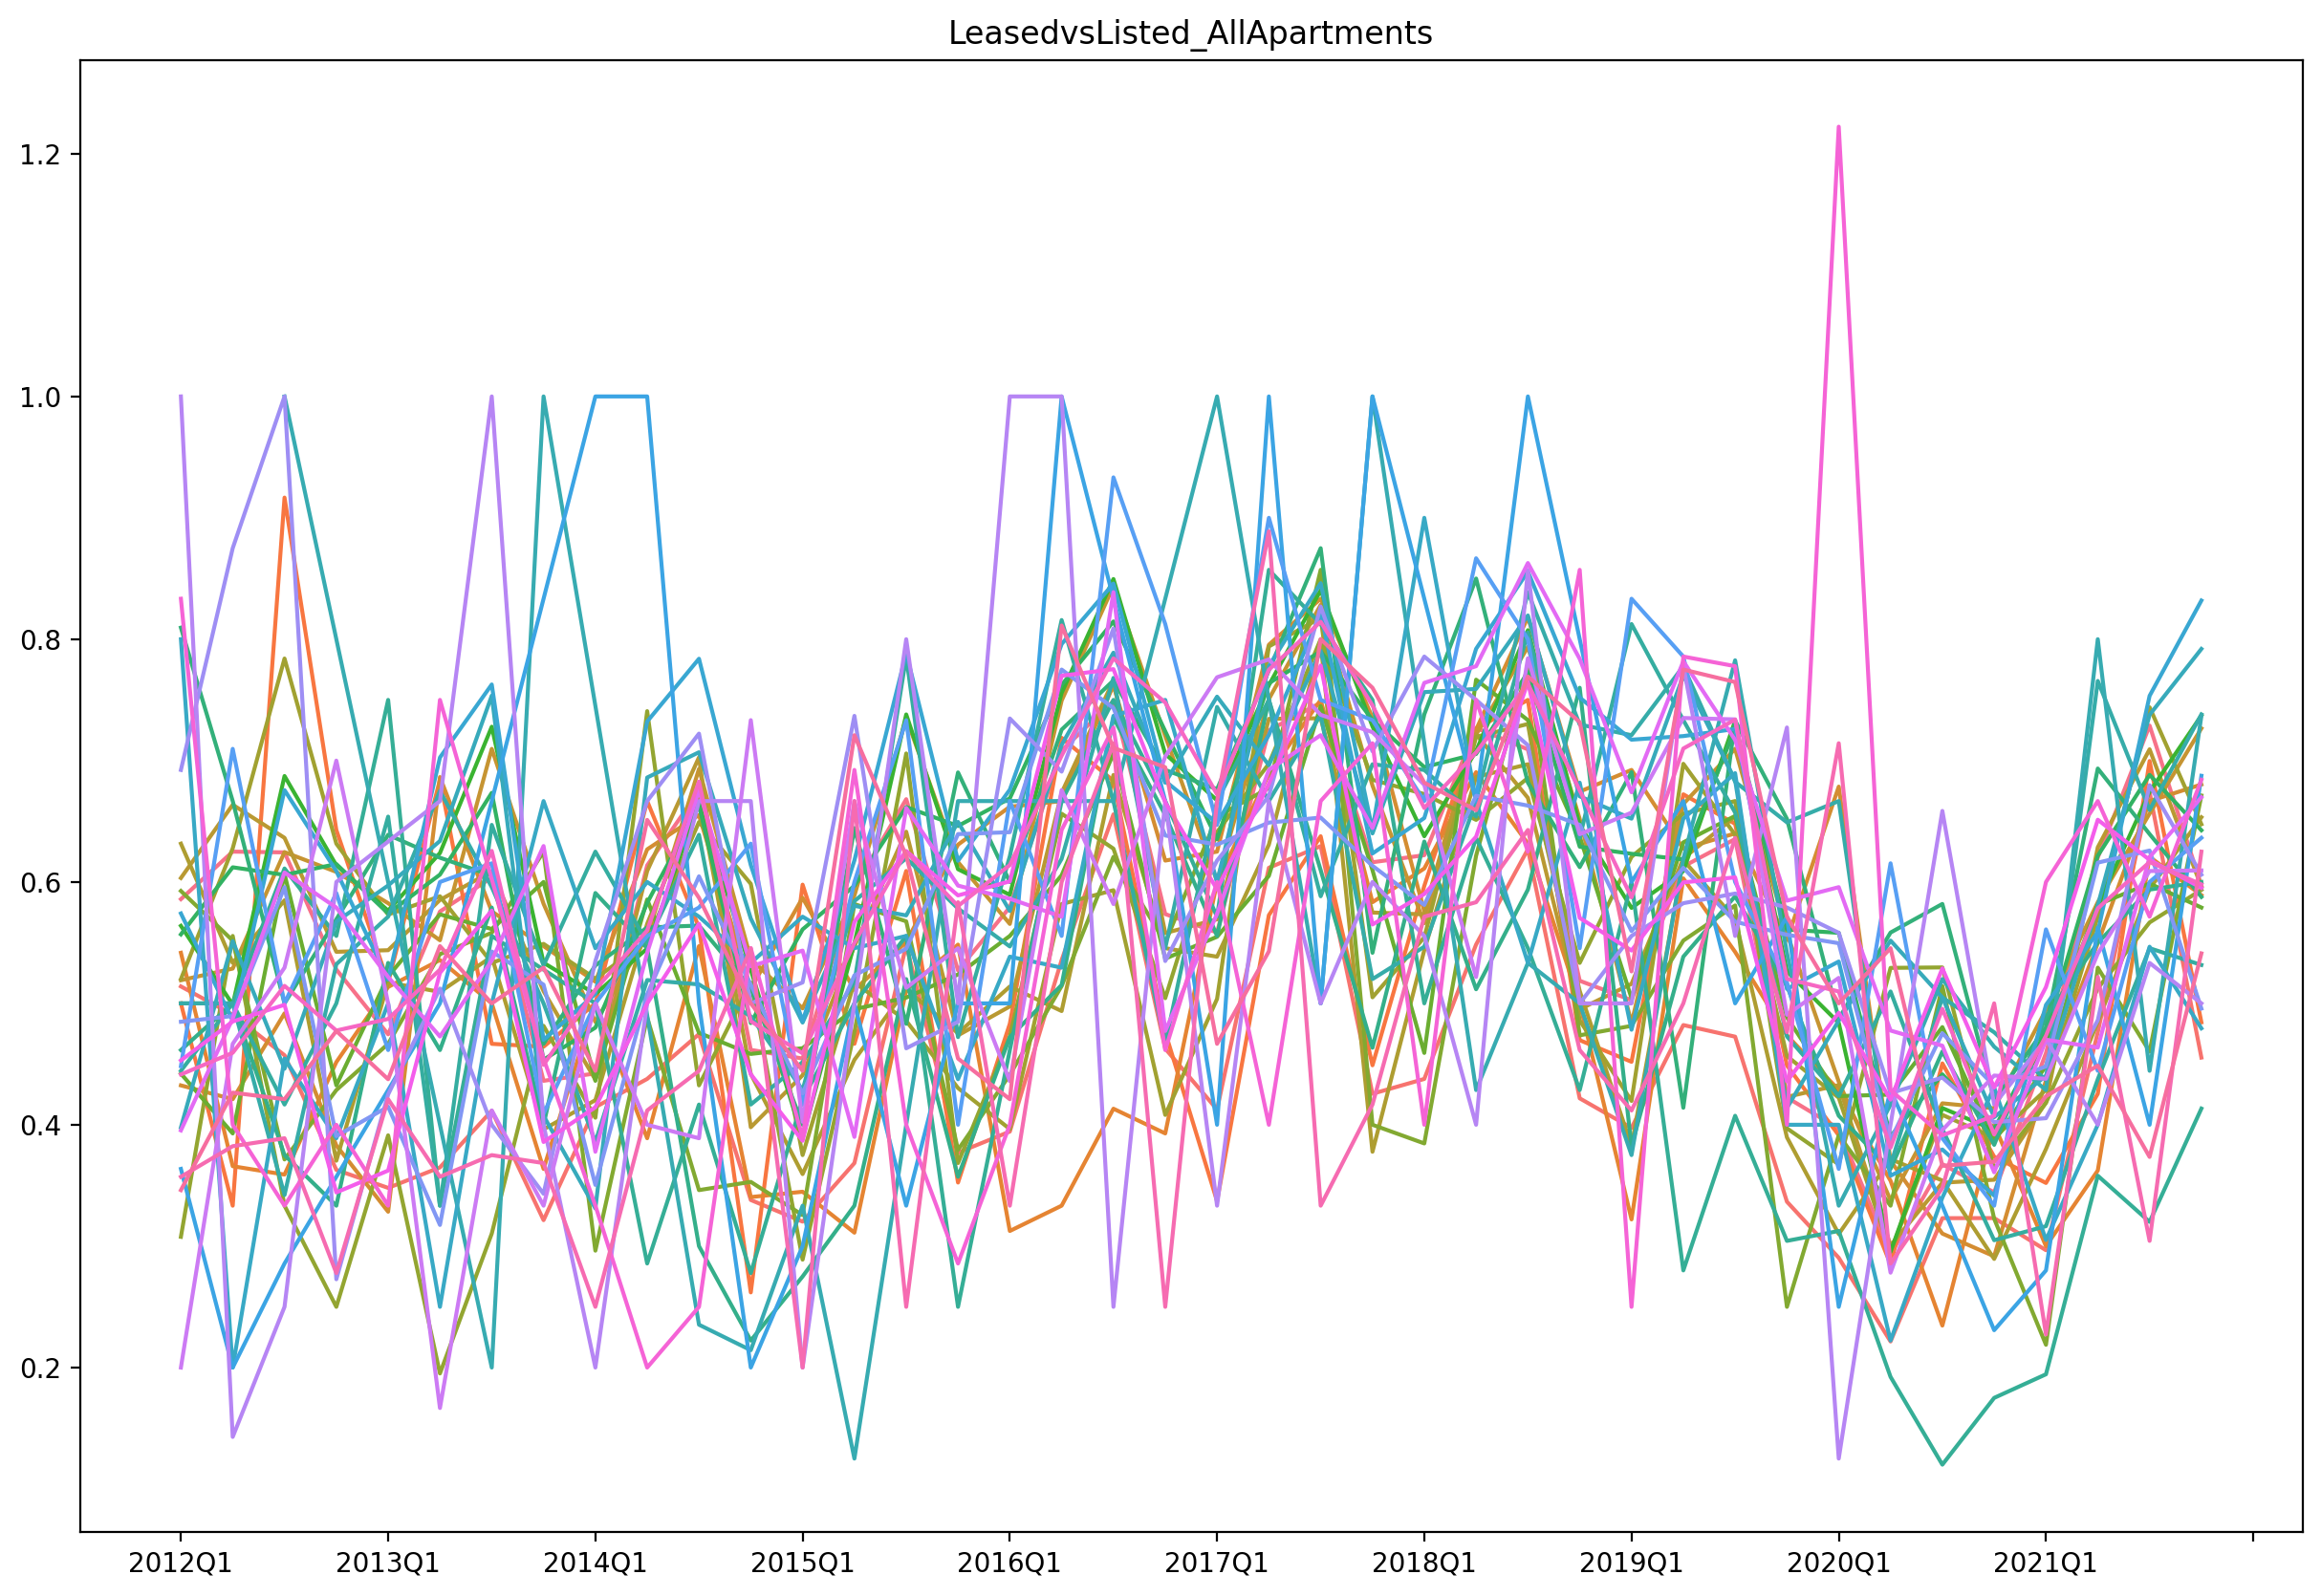

In [95]:
rent['LeasedvsListed_AllApartments'] = rent['Leased_AllApartments'] / rent['Listed_AllApartments']
ax = sns.lineplot(x='YearQuarter', y='LeasedvsListed_AllApartments', data=rent, hue='district', legend=False)
ax.title.set_text('LeasedvsListed_AllApartments')
ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))

In [96]:
# number of leased units / number of listing cannot be > 1
rent[['district', 'LeasedvsListed_AllApartments']].sort_values(by='LeasedvsListed_AllApartments', ascending=False).head(5)

district  LeasedvsListed_AllApartments
1272      W07                      1.222222
1080      W03                      1.000000
762       E06                      1.000000
1086      W03                      1.000000
943       E10                      1.000000

In [98]:
# identify the problematic record 
location = np.where(rent['LeasedvsListed_AllApartments'] == rent['LeasedvsListed_AllApartments'].max())[0][0]
rent.loc[location:location,]

district  Listed_AllApartments  Leased_AllApartments  \
1272      W07                   9.0                  11.0   

      TotalLeased_Bachelor  AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  \
1272                   NaN                    NaN                     5.0   

      AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  \
1272                   2010.0                     6.0   

      AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
1272                   2900.0                       NaN   

      AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
1272                        NaN  2020        1      2020Q1   

      LeasedvsListed_AllApartments  
1272                      1.222222

In [99]:
# fix the number of listing = number of leased
rent.loc[location:location, 'Listed_AllApartments'] = rent.loc[location:location, 'Leased_AllApartments']
rent.loc[location:location, 'LeasedvsListed_AllApartments'] = 1
rent.loc[location:location,]

district  Listed_AllApartments  Leased_AllApartments  \
1272      W07                  11.0                  11.0   

      TotalLeased_Bachelor  AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  \
1272                   NaN                    NaN                     5.0   

      AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  \
1272                   2010.0                     6.0   

      AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
1272                   2900.0                       NaN   

      AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
1272                        NaN  2020        1      2020Q1   

      LeasedvsListed_AllApartments  
1272                           1.0

# Plot lease counts and rates

In [100]:
rent.columns

Index(['district', 'Listed_AllApartments', 'Leased_AllApartments',
       'TotalLeased_Bachelor', 'AvgLeaseRate_Bachelor',
       'TotalLeased_OneBedroom', 'AvgLeaseRate_OneBedroom',
       'TotalLeased_TwoBedroom', 'AvgLeaseRate_TwoBedroom',
       'TotalLeased_ThreeBedroom', 'AvgLeaseRate_ThreeBedroom', 'Year',
       'Quarter', 'YearQuarter', 'LeasedvsListed_AllApartments'],
      dtype='object')

In [101]:
lease_rates = [re.search('AvgLeaseRate_\w+', x).group(0) for x in rent.columns if re.search('AvgLeaseRate_\w+', x) is not None]
lease_count = [re.search('TotalLeased_\w+', x).group(0) for x in rent.columns if re.search('TotalLeased_\w+', x) is not None]

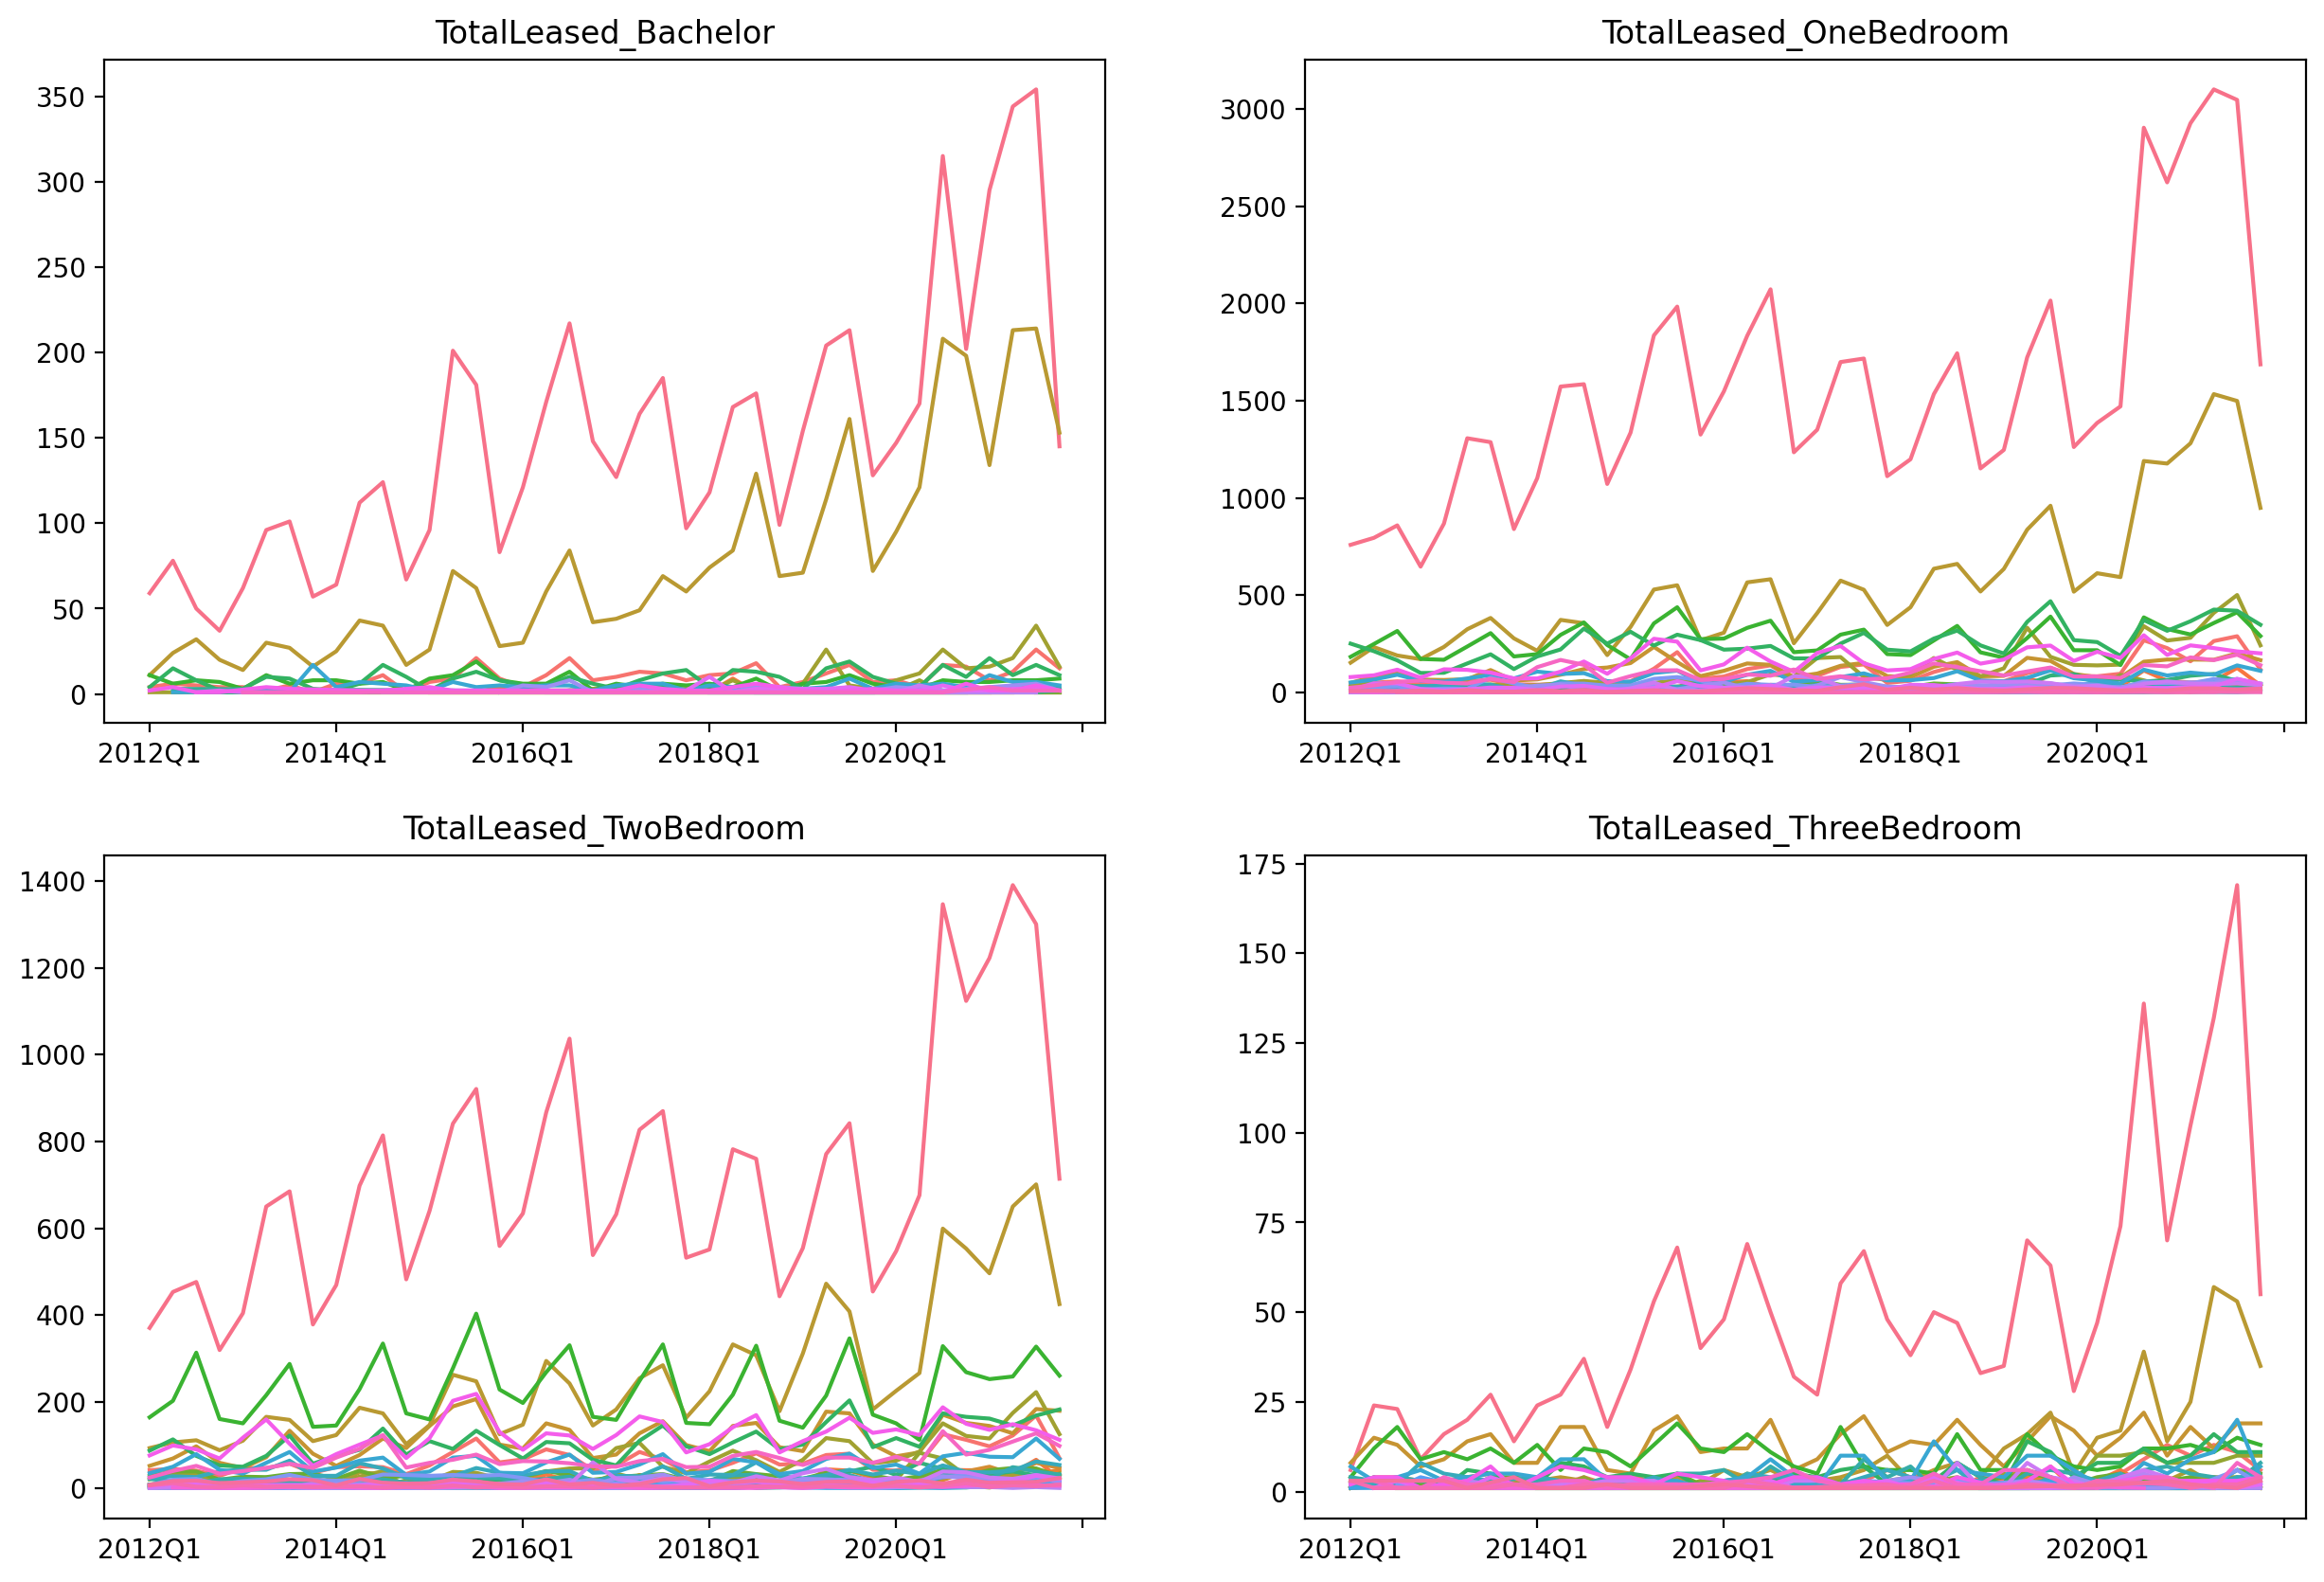

In [102]:
# plotting number of leased apartments by district
fig, axes = plt.subplots(int(len(lease_count)/2),2)
for col, ax in zip(lease_count, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rent, hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))

In [103]:
# As expexted, C08 and C01 are the districts closest to downtown
print("Top 5 districts by number of leased apartments:")
rent[rent['YearQuarter'] == '2021Q4'].groupby('district').TotalLeased_Bachelor.mean().sort_values(ascending=False).head()

Top 5 districts by number of leased apartments:


district
C08    153.0
C01    145.0
C10     16.0
C02     15.0
C15     11.0
Name: TotalLeased_Bachelor, dtype: float64

Text(0.5, 0.98, 'Excluding C08 and C01')

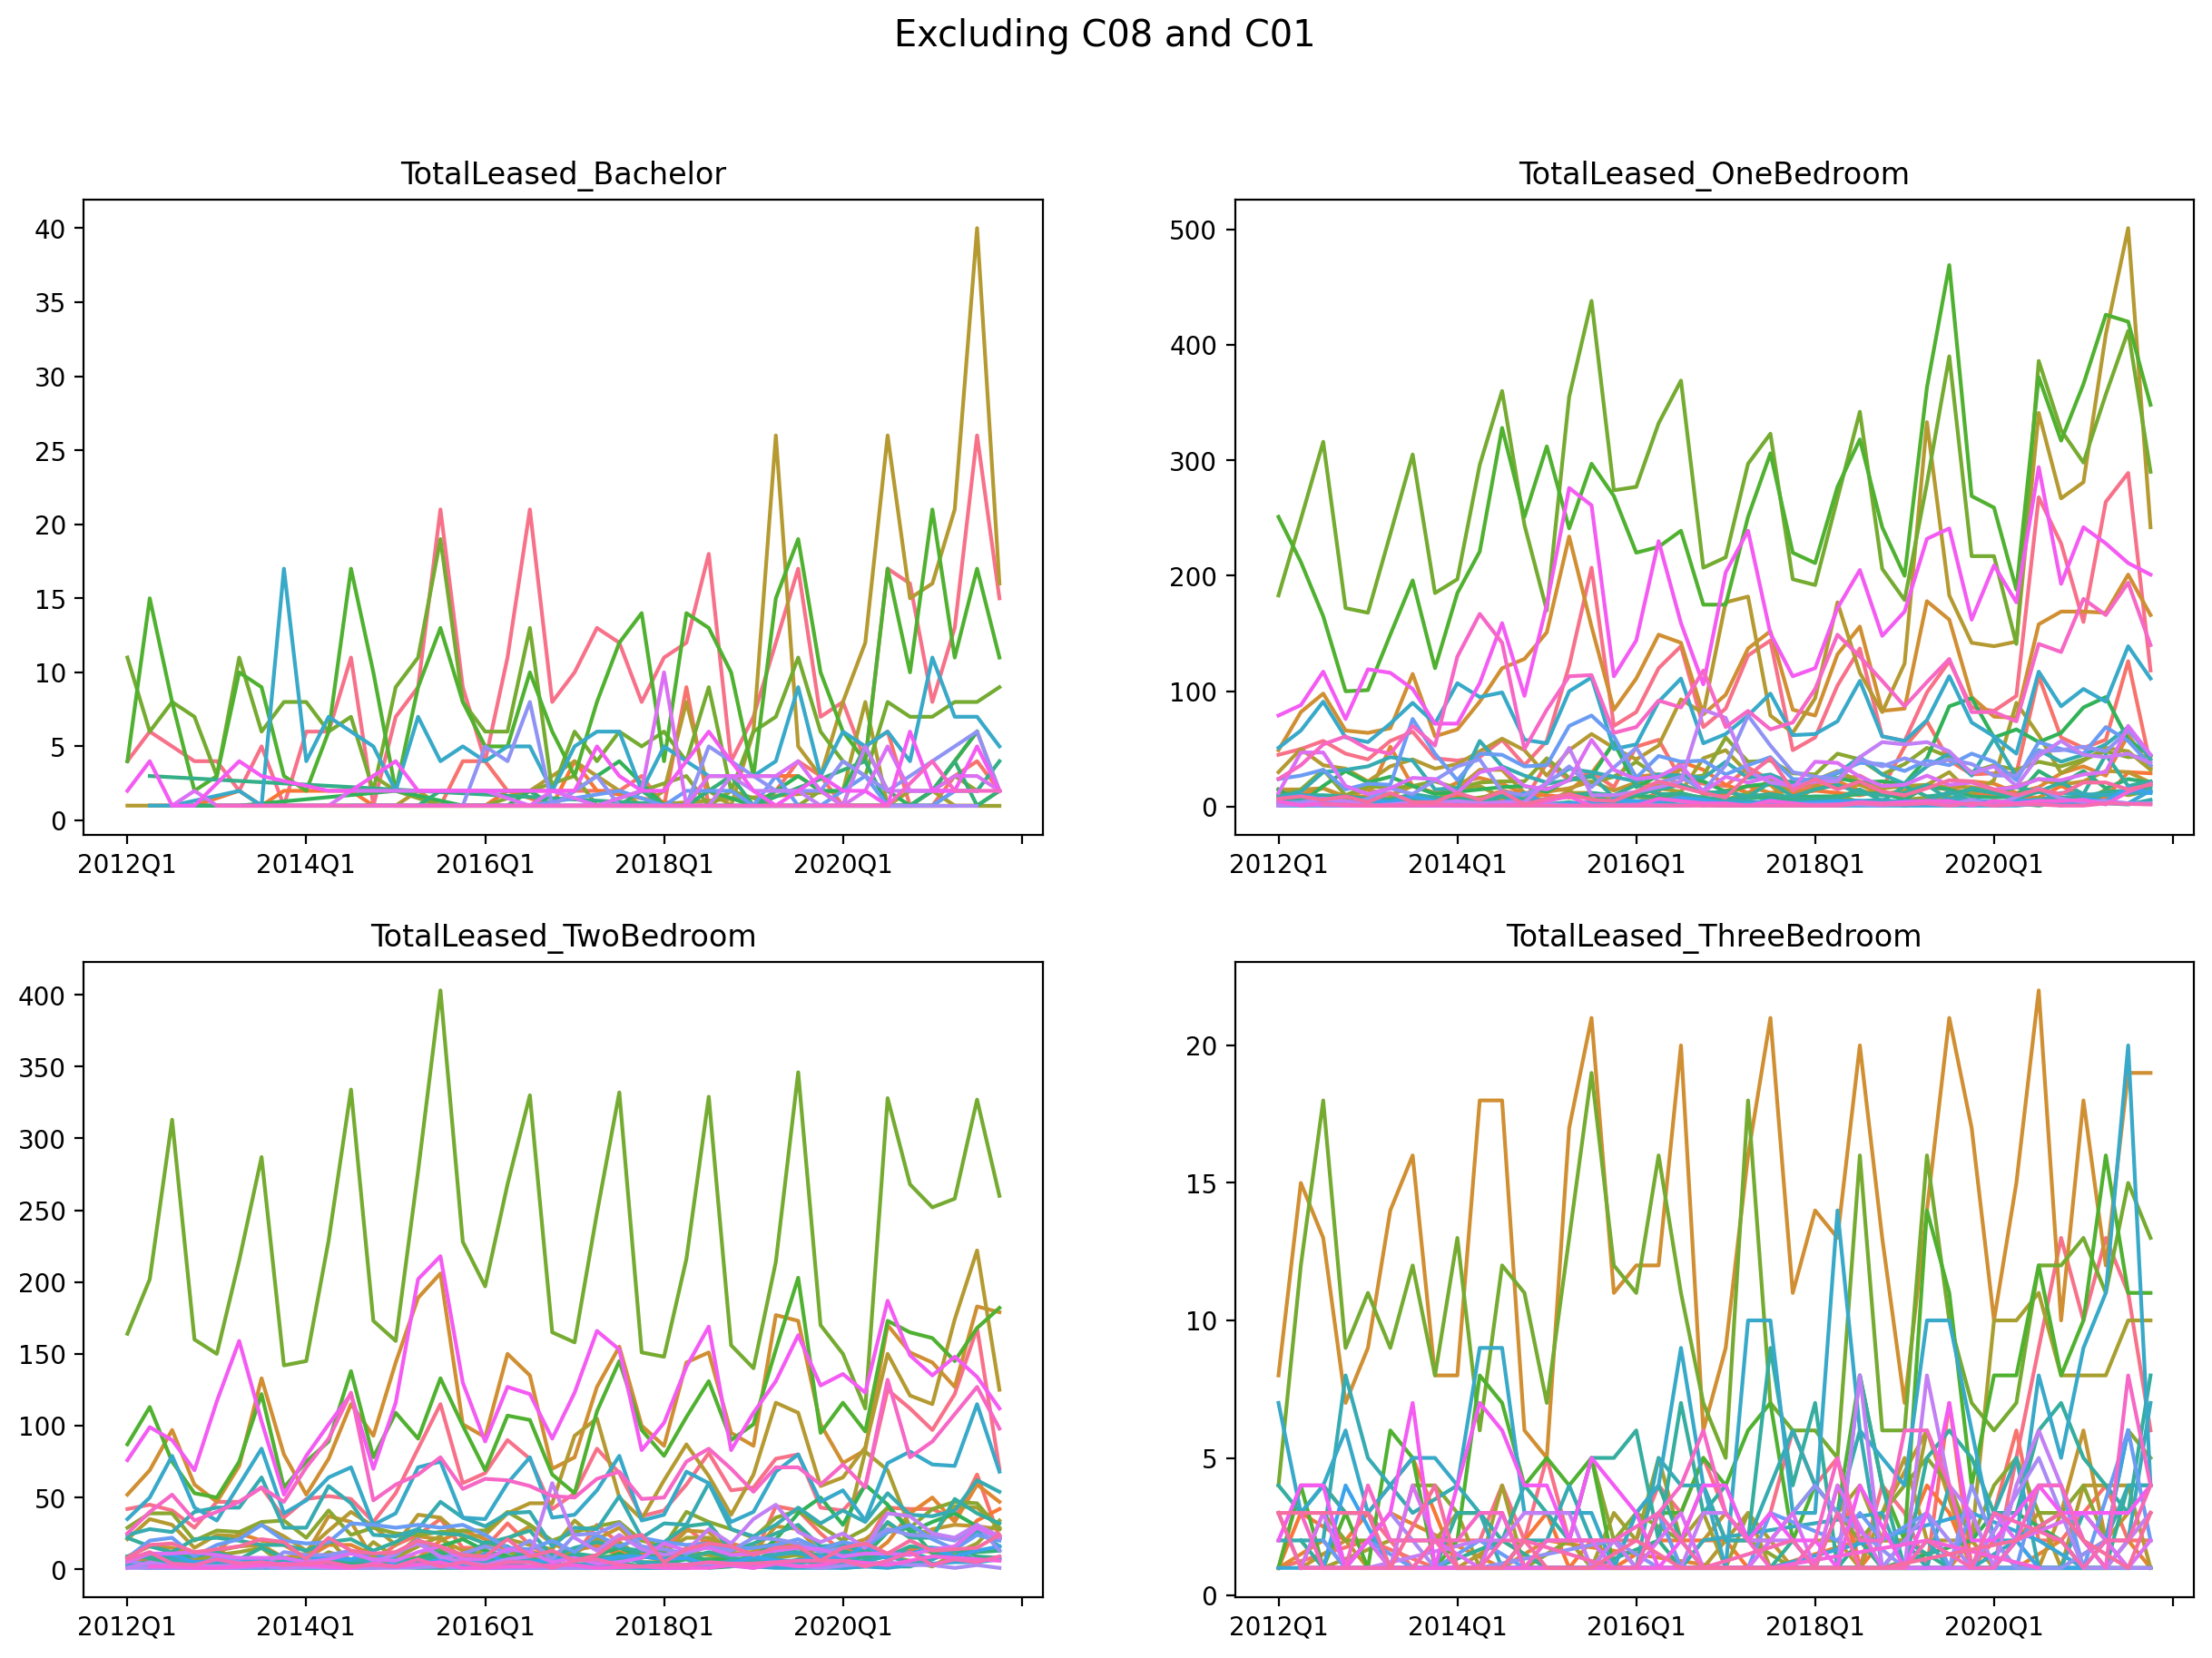

In [104]:
# Exclude the top 2 districts
fig, axes = plt.subplots(int(len(lease_count)/2),2)
for col, ax in zip(lease_count, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rent[~(rent['district'].isin(['C08', 'C01']))], hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))
fig.suptitle('Excluding C08 and C01', size = 'x-large')

# Fix average lease rate

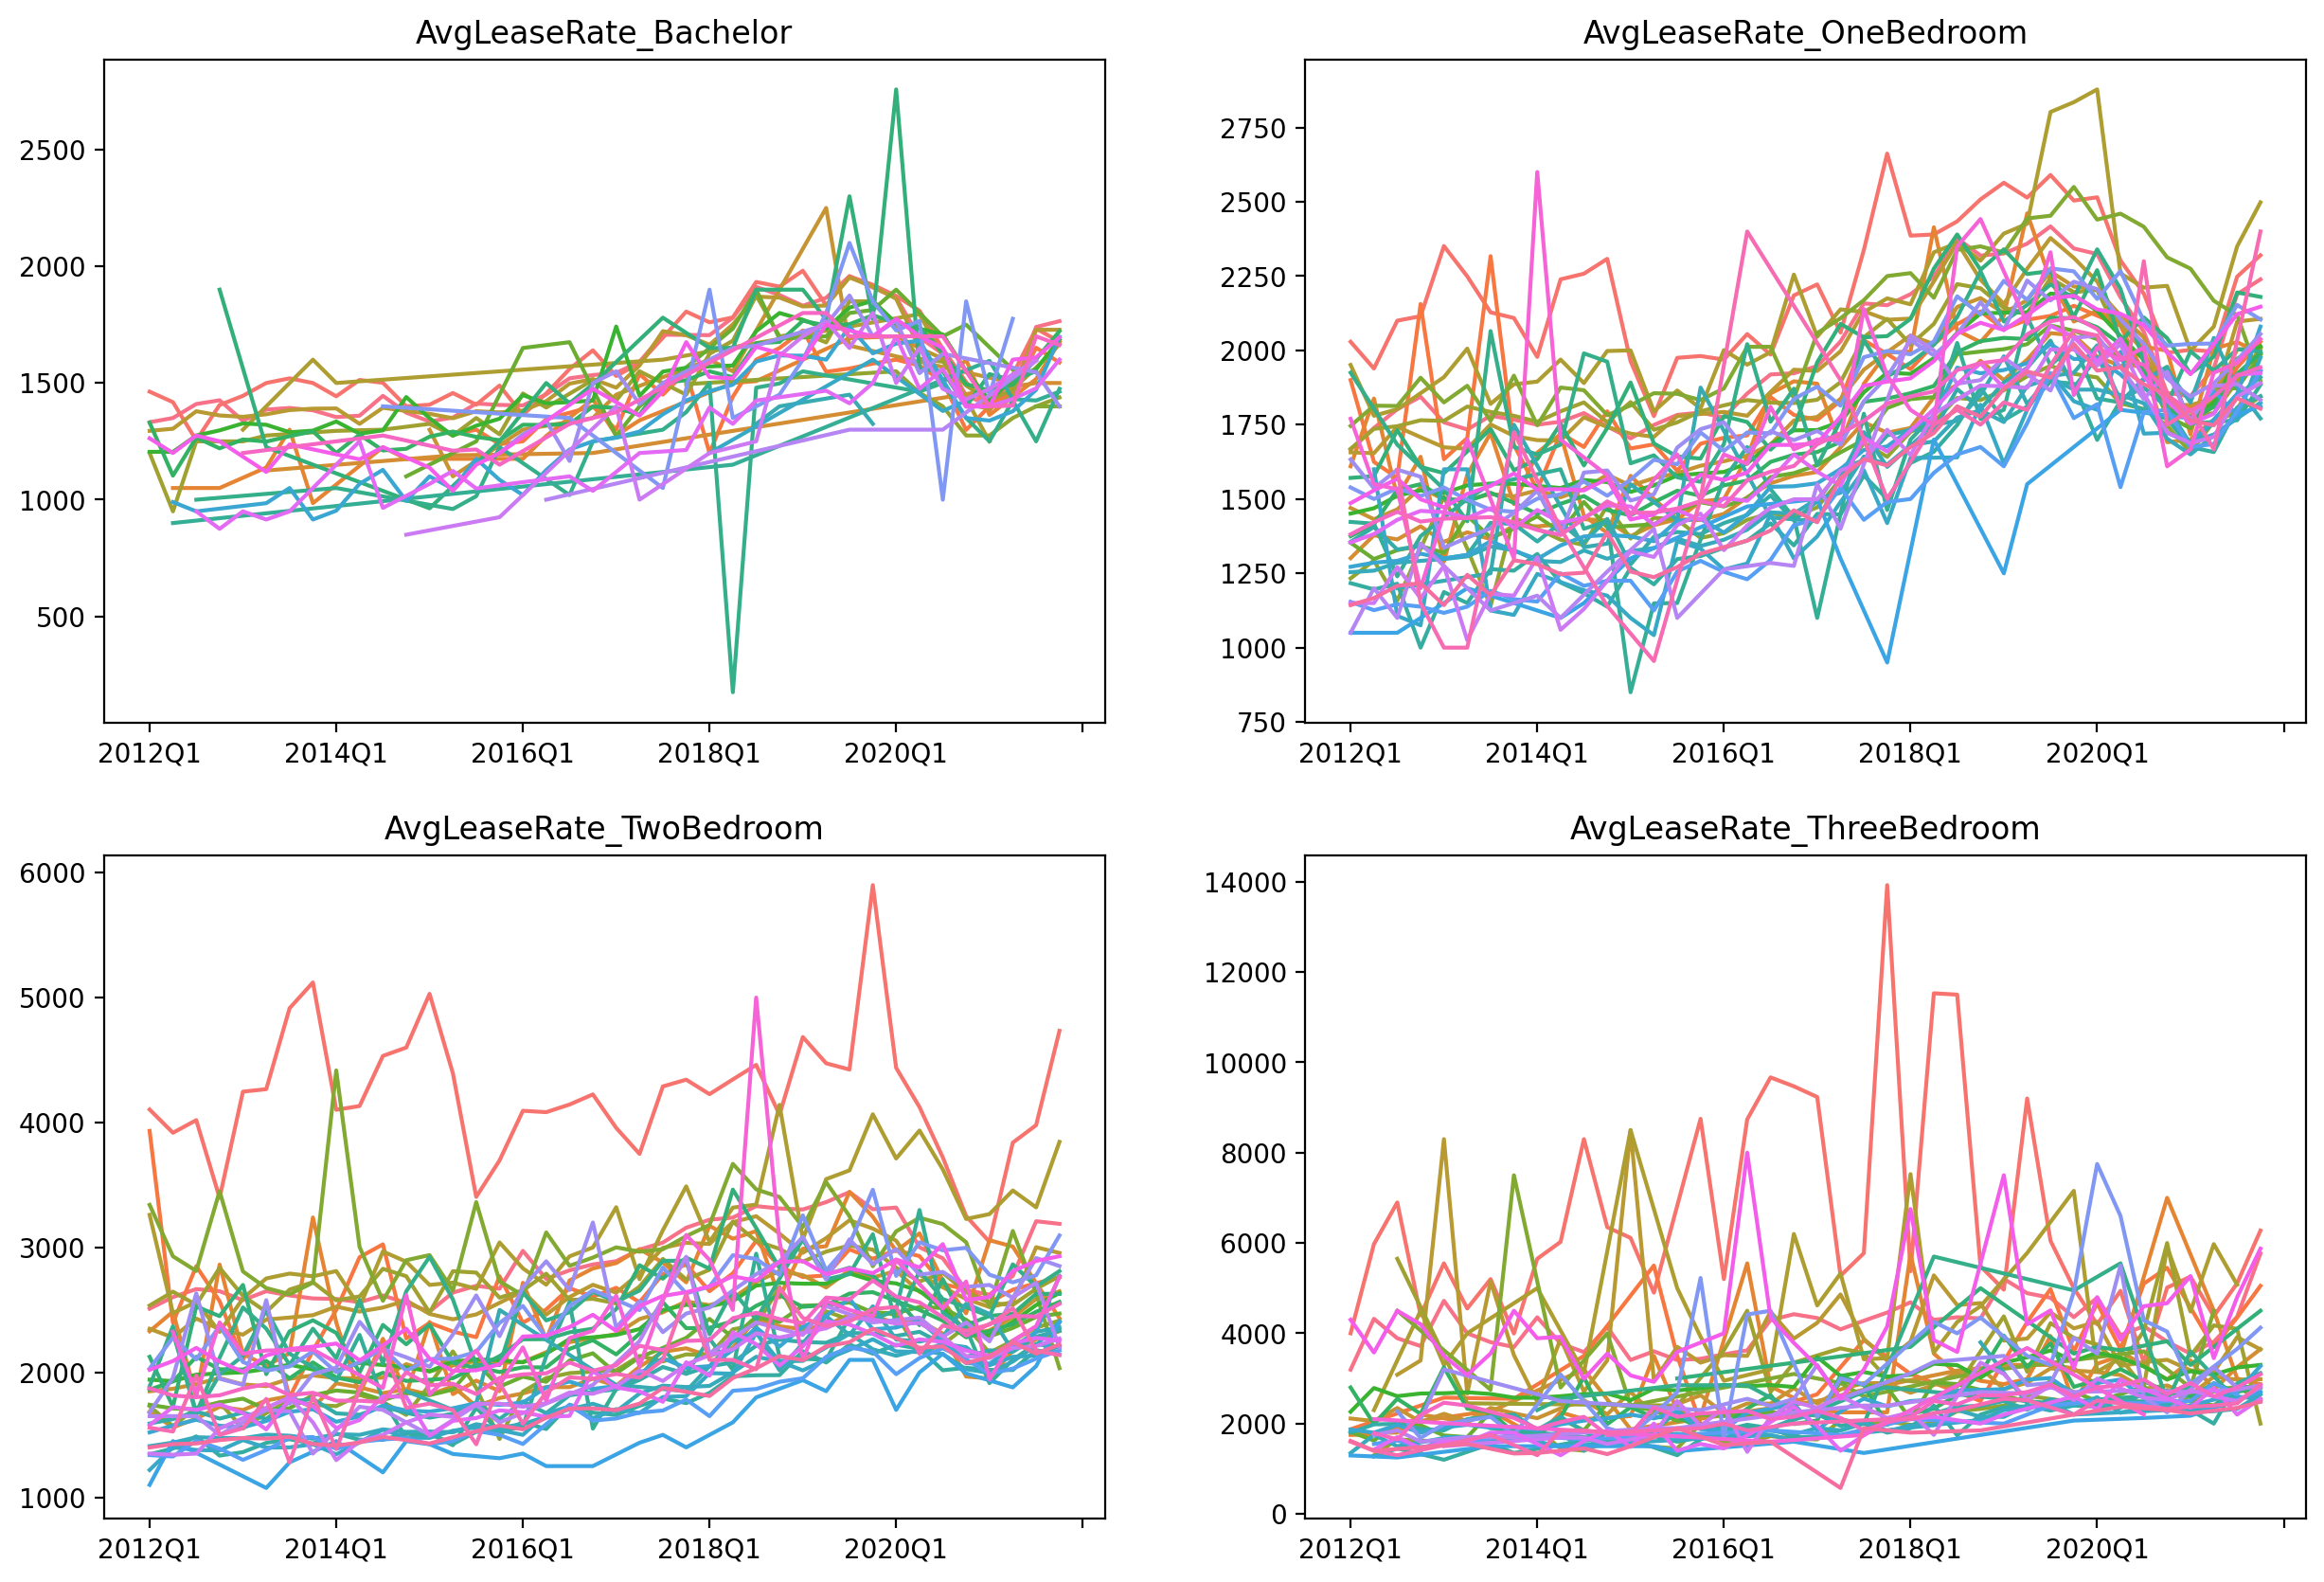

In [105]:
# plotting average lease rates of apartments by district
fig, axes = plt.subplots(int(len(lease_rates)/2),2)
for col, ax in zip(lease_rates, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rent, hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))

In [106]:
# the suddent dip in lease rate of bachelor apartments may not make sense
location = np.where(rent['AvgLeaseRate_Bachelor'] == rent['AvgLeaseRate_Bachelor'].min())[0][0]
rent.loc[(location-1):(location+1),['district', 'AvgLeaseRate_Bachelor', 'YearQuarter']]

district  AvgLeaseRate_Bachelor YearQuarter
624      E02                 1500.0      2018Q1
625      E02                  175.0      2018Q2
626      E02                 1480.0      2018Q3

In [107]:
# $175 per month for a bachelor does not make sense
# could be manual error for missing a zero in input
# let's remove the weird data point
rent.loc[location, 'AvgLeaseRate_Bachelor'] = np.nan
rent.loc[(location-1):(location+1),['district', 'AvgLeaseRate_Bachelor', 'YearQuarter']]

district  AvgLeaseRate_Bachelor YearQuarter
624      E02                 1500.0      2018Q1
625      E02                    NaN      2018Q2
626      E02                 1480.0      2018Q3

In [108]:
trreb_total = pd.concat(trreb_dfs, axis=0)
trreb_total.reset_index(drop=True, inplace=True)
trreb_total.head()

district  Listed_AllApartments  Leased_AllApartments  \
0  TREB Total                  7096                  3804   
1  TREB Total                  8893                  4771   
2  TREB Total                  8845                  5241   
3  TREB Total                  7161                  3648   
4  TREB Total                  8816                  4277   

   TotalLeased_Bachelor  AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  \
0                    96                   1306                    2111   
1                   143                   1285                    2552   
2                   119                   1336                    2733   
3                    81                   1359                    1982   
4                    97                   1308                    2380   

   AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  AvgLeaseRate_TwoBedroom  \
0                     1538                    1522                     2089   
1                     1556                    1950                     2088   
2                     1605                    2250                     2097   
3                     1626                    1486                     2088   
4                     1597                    1700                     2114   

   TotalLeased_ThreeBedroom  AvgLeaseRate_ThreeBedroom  Year  Quarter  
0                        75                       2079  2012        1  
1                       126                       2625  2012        2  
2                       139                       2660  2012        3  
3                        99                       2327  2012        4  
4                       100                       2737  2013        1

In [109]:
rent

district  Listed_AllApartments  Leased_AllApartments  \
0         C01                2038.0                1194.0   
1         C01                2160.0                1350.0   
2         C01                2255.0                1408.0   
3         C01                1917.0                1012.0   
4         C01                2845.0                1350.0   
...       ...                   ...                   ...   
1395      W10                  92.0                  34.0   
1396      W10                  85.0                  36.0   
1397      W10                  78.0                  35.0   
1398      W10                  83.0                  31.0   
1399      W10                  85.0                  46.0   

      TotalLeased_Bachelor  AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  \
0                     59.0                 1332.0                   759.0   
1                     78.0                 1350.0                   795.0   
2                     50.0                 1410.0                   859.0   
3                     37.0                 1426.0                   647.0   
4                     62.0                 1338.0                   868.0   
...                    ...                    ...                     ...   
1395                   NaN                    NaN                    11.0   
1396                   NaN                    NaN                    21.0   
1397                   NaN                    NaN                    21.0   
1398                   NaN                    NaN                    15.0   
1399                   NaN                    NaN                    19.0   

      AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  \
0                      1666.0                   370.0   
1                      1739.0                   453.0   
2                      1802.0                   476.0   
3                      1844.0                   319.0   
4                      1758.0                   404.0   
...                       ...                     ...   
1395                   1850.0                    20.0   
1396                   1764.0                    13.0   
1397                   1748.0                    14.0   
1398                   1839.0                    15.0   
1399                   1804.0                    24.0   

      AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
0                      2510.0                       6.0   
1                      2603.0                      24.0   
2                      2667.0                      23.0   
3                      2650.0                       9.0   
4                      2578.0                      16.0   
...                       ...                       ...   
1395                   2075.0                       3.0   
1396                   2123.0                       2.0   
1397                   2243.0                       NaN   
1398                   2150.0                       1.0   
1399                   2223.0                       3.0   

      AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
0                        3194.0  2012        1      2012Q1   
1                        4321.0  2012        2      2012Q2   
2                        3891.0  2012        3      2012Q3   
3                        3717.0  2012        4      2012Q4   
4                        4719.0  2013        1      2013Q1   
...                         ...   ...      ...         ...   
1395                     2300.0  2020        4      2020Q4   
1396                     2225.0  2021        1      2021Q1   
1397                        NaN  2021        2      2021Q2   
1398                     2350.0  2021        3      2021Q3   
1399                     2483.0  2021        4      2021Q4   

      LeasedvsListed_AllApartments  
0                         0.585868  
1                         0.625000  
2                         0.624390  
3                         0.527908  
4                      

# Check missing data

<AxesSubplot:>

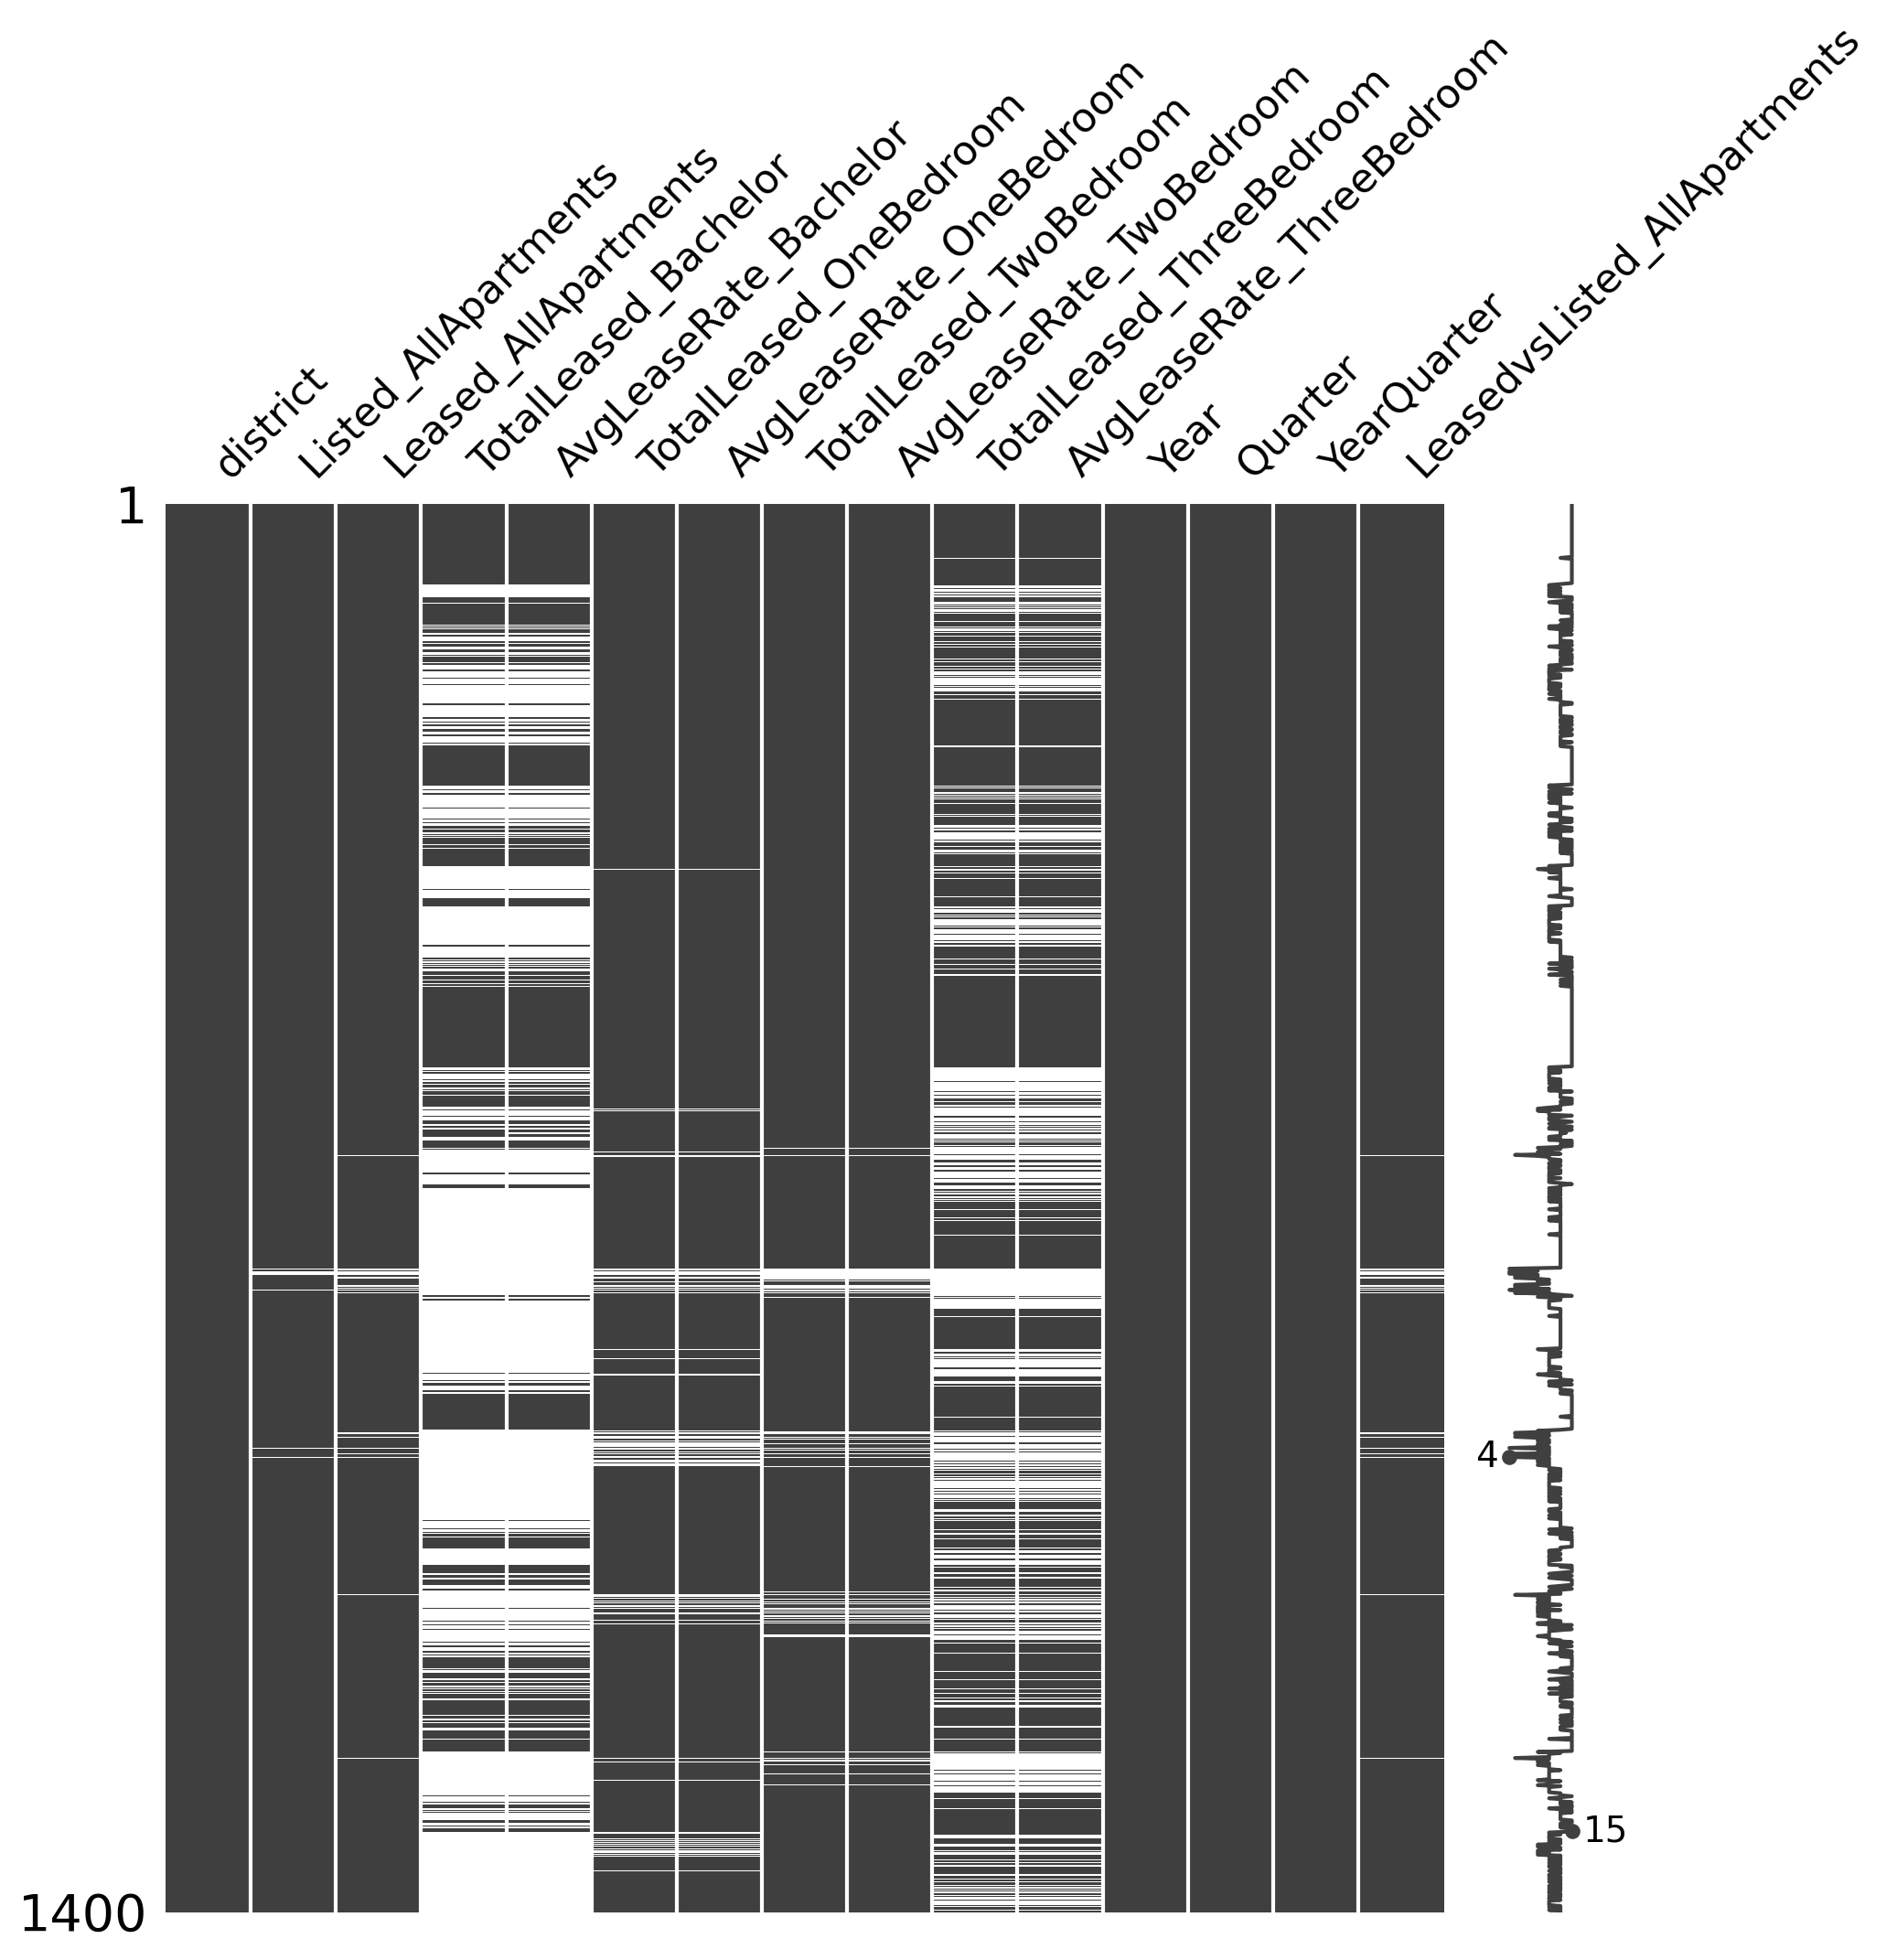

In [110]:
msno.matrix(rent, figsize=(10,10))

In [111]:
print("Percentage of missing data")
(rent.isna().sum(axis=0).sort_values(ascending=False) / rent.shape[0])*100

Percentage of missing data


AvgLeaseRate_Bachelor           60.357143
TotalLeased_Bachelor            60.285714
TotalLeased_ThreeBedroom        33.785714
AvgLeaseRate_ThreeBedroom       33.785714
TotalLeased_OneBedroom           5.142857
AvgLeaseRate_OneBedroom          5.142857
TotalLeased_TwoBedroom           3.928571
AvgLeaseRate_TwoBedroom          3.928571
Leased_AllApartments             1.500000
LeasedvsListed_AllApartments     1.500000
Listed_AllApartments             0.500000
district                         0.000000
Year                             0.000000
Quarter                          0.000000
YearQuarter                      0.000000
dtype: float64

# Drop bachelor apartments

In [112]:
# drop Bachelor apartments columns since over 50% of the data is missing
rent.drop(columns=['AvgLeaseRate_Bachelor', 'TotalLeased_Bachelor'], inplace=True)

# Interpolate NA values

In [113]:
# check rows with na
na_index = rent[rent.isna().sum(axis=1) != 0].head(1).index[0]
rent.iloc[(na_index - 1):(na_index + 2)]

district  Listed_AllApartments  Leased_AllApartments  \
53      C02                 589.0                 217.0   
54      C02                 626.0                 343.0   
55      C02                 374.0                 141.0   

    TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  \
53                   122.0                   1779.0                    84.0   
54                   207.0                   1975.0                   115.0   
55                    70.0                   1981.0                    60.0   

    AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
53                   4394.0                       2.0   
54                   3405.0                       NaN   
55                   3697.0                       2.0   

    AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
53                     4900.0  2015        2      2015Q2   
54                        NaN  2015        3      2015Q3   
55                     8750.0  2015        4      2015Q4   

    LeasedvsListed_AllApartments  
53                      0.368421  
54                      0.547923  
55                      0.377005

In [114]:
# missing data interpolated
pd.DataFrame(rent.iloc[(na_index - 1):(na_index + 2)]).interpolate(method='linear', axis=0)

district  Listed_AllApartments  Leased_AllApartments  \
53      C02                 589.0                 217.0   
54      C02                 626.0                 343.0   
55      C02                 374.0                 141.0   

    TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  \
53                   122.0                   1779.0                    84.0   
54                   207.0                   1975.0                   115.0   
55                    70.0                   1981.0                    60.0   

    AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
53                   4394.0                       2.0   
54                   3405.0                       2.0   
55                   3697.0                       2.0   

    AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
53                     4900.0  2015        2      2015Q2   
54                     6825.0  2015        3      2015Q3   
55                     8750.0  2015        4      2015Q4   

    LeasedvsListed_AllApartments  
53                      0.368421  
54                      0.547923  
55                      0.377005

In [115]:
# first interpolate within each neighbourhood only
# then assume the first record is NA, we do backward fill within each neighbourhood
for district in rent.district.unique():
    # rent.loc[rent['district'] == district] = rent.loc[rent['district'] == district].ffill(axis=0).bfill(axis=0).values
    rent.loc[rent['district'] == district] = rent.loc[rent['district'] == district].interpolate(method='linear', axis=0).bfill(axis=0).values

In [116]:
print("Percentage of missing data")
(rent.isna().sum(axis=0).sort_values(ascending=False) / rent.shape[0])*100

Percentage of missing data


district                        0.0
Listed_AllApartments            0.0
Leased_AllApartments            0.0
TotalLeased_OneBedroom          0.0
AvgLeaseRate_OneBedroom         0.0
TotalLeased_TwoBedroom          0.0
AvgLeaseRate_TwoBedroom         0.0
TotalLeased_ThreeBedroom        0.0
AvgLeaseRate_ThreeBedroom       0.0
Year                            0.0
Quarter                         0.0
YearQuarter                     0.0
LeasedvsListed_AllApartments    0.0
dtype: float64

# Add per-bedroom statistics 

In [118]:
room_types = [re.search("TotalLeased_(\w+)", x).group(1) for x in rent.columns if re.search("TotalLeased_(\w+)", x) is not None]
room_types

['OneBedroom', 'TwoBedroom', 'ThreeBedroom']

In [119]:
# to compare number of leased aparatments and lease rates across different room types
# we must normalize by the number of rooms
for type in room_types:
    
    if type == 'OneBedroom':
        room_num = 1
    elif type == 'TwoBedroom':
        room_num = 2
    elif type == 'ThreeBedroom':
        room_num = 3
    
    # for number of leased apartments, we multiply by the number of bedrooms
    # e.g. 1 listing of 3-bedroom apartment = 3 listings of 1-bedroom apartment
    rent['TotalLeasedPerRoom_' + type] = rent['TotalLeased_' + type] * room_num
    
    # for number of leased apartments, we divide by the number of bedrooms
    # since you split the cost with your roommates
    rent['AvgLeaseRatePerRoom_' + type] = rent['AvgLeaseRate_' + type] / room_num

In [166]:
for agg_type in ['AllApartments', 'SharedApartments']:
    rent['TotalLeased_' + agg_type] = 0
    rent['TotalLeasedPerRoom_' + agg_type] = 0
    rent['AvgLeaseRate_' + agg_type] = 0
    rent['AvgLeaseRatePerRoom_' + agg_type] = 0
    if agg_type == 'AllApartments':
        room_list = room_types
    elif agg_type == 'SharedApartments':
        room_list = ['TwoBedroom', 'ThreeBedroom']
    for room in room_list:
        rent['TotalLeased_' + agg_type] += rent['TotalLeased_' + room]
        rent['AvgLeaseRate_' + agg_type] += rent['AvgLeaseRate_' + room] * rent['TotalLeased_' + room]
        rent['TotalLeasedPerRoom_' + agg_type] += rent['TotalLeasedPerRoom_' + room]
        rent['AvgLeaseRatePerRoom_' + agg_type] += rent['AvgLeaseRatePerRoom_' + room] * rent['TotalLeasedPerRoom_' + room]

    rent['AvgLeaseRate_' + agg_type] = rent['AvgLeaseRate_' + agg_type] / rent['TotalLeased_' + agg_type]
    rent['AvgLeaseRatePerRoom_' + agg_type] = rent['AvgLeaseRatePerRoom_' + agg_type] / rent['TotalLeasedPerRoom_' + agg_type]

In [167]:
rent

district  Listed_AllApartments  Leased_AllApartments  \
0         C01                2038.0                1194.0   
1         C01                2160.0                1350.0   
2         C01                2255.0                1408.0   
3         C01                1917.0                1012.0   
4         C01                2845.0                1350.0   
...       ...                   ...                   ...   
1395      W10                  92.0                  34.0   
1396      W10                  85.0                  36.0   
1397      W10                  78.0                  35.0   
1398      W10                  83.0                  31.0   
1399      W10                  85.0                  46.0   

      TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  \
0                      759.0                   1666.0                   370.0   
1                      795.0                   1739.0                   453.0   
2                      859.0                   1802.0                   476.0   
3                      647.0                   1844.0                   319.0   
4                      868.0                   1758.0                   404.0   
...                      ...                      ...                     ...   
1395                    11.0                   1850.0                    20.0   
1396                    21.0                   1764.0                    13.0   
1397                    21.0                   1748.0                    14.0   
1398                    15.0                   1839.0                    15.0   
1399                    19.0                   1804.0                    24.0   

      AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
0                      2510.0                       6.0   
1                      2603.0                      24.0   
2                      2667.0                      23.0   
3                      2650.0                       9.0   
4                      2578.0                      16.0   
...                       ...                       ...   
1395                   2075.0                       3.0   
1396                   2123.0                       2.0   
1397                   2243.0                       1.5   
1398                   2150.0                       1.0   
1399                   2223.0                       3.0   

      AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
0                        3194.0  2012        1      2012Q1   
1                        4321.0  2012        2      2012Q2   
2                        3891.0  2012        3      2012Q3   
3                        3717.0  2012        4      2012Q4   
4                        4719.0  2013        1      2013Q1   
...                         ...   ...      ...         ...   
1395                     2300.0  2020        4      2020Q4   
1396                     2225.0  2021        1      2021Q1   
1397                     2287.5  2021        2      2021Q2   
1398                     2350.0  2021        3      2021Q3   
1399                     2483.0  2021        4      2021Q4   

      LeasedvsListed_AllApartments  TotalLeasedPerRoom_OneBedroom  \
0                         0.585868                          759.0   
1                         0.625000                          795.0   
2                         0.624390                          859.0   
3                         0.527908                          647.0   
4                         0.474517                          868.0   
...                            ...                            ...   
1395                      0.369565                           11.0   
1396                      0.423529                           21.0   
1397                      0.448718                           21.0   
1398                      0.373494                           15.0   
1399                      0.541176                           19.0   

      AvgLeaseRa

# Output

In [168]:
# specify separator and suffix
rent_output = pd.wide_to_long(
    rent, 
    stubnames=['TotalLeased', 'AvgLeaseRate', 'TotalLeasedPerRoom', 'AvgLeaseRatePerRoom'], 
    i=['district', 'Listed_AllApartments', 'Leased_AllApartments', 'LeasedvsListed_AllApartments', 'Year', 'Quarter', 'YearQuarter'], 
    j='RoomType', 
    sep='_',
    suffix='\w+'
    ).reset_index()

In [169]:
rent_output

district  Listed_AllApartments  Leased_AllApartments  \
0         C01                2038.0                1194.0   
1         C01                2038.0                1194.0   
2         C01                2038.0                1194.0   
3         C01                2038.0                1194.0   
4         C01                2038.0                1194.0   
...       ...                   ...                   ...   
6995      W10                  85.0                  46.0   
6996      W10                  85.0                  46.0   
6997      W10                  85.0                  46.0   
6998      W10                  85.0                  46.0   
6999      W10                  85.0                  46.0   

      LeasedvsListed_AllApartments  Year  Quarter YearQuarter  \
0                         0.585868  2012        1      2012Q1   
1                         0.585868  2012        1      2012Q1   
2                         0.585868  2012        1      2012Q1   
3                         0.585868  2012        1      2012Q1   
4                         0.585868  2012        1      2012Q1   
...                            ...   ...      ...         ...   
6995                      0.541176  2021        4      2021Q4   
6996                      0.541176  2021        4      2021Q4   
6997                      0.541176  2021        4      2021Q4   
6998                      0.541176  2021        4      2021Q4   
6999                      0.541176  2021        4      2021Q4   

              RoomType  TotalLeased  AvgLeaseRate  TotalLeasedPerRoom  \
0           OneBedroom        759.0   1666.000000               759.0   
1           TwoBedroom        370.0   2510.000000               740.0   
2         ThreeBedroom          6.0   3194.000000                18.0   
3        AllApartments       1135.0   1949.214097              1517.0   
4     SharedApartments        376.0   2520.914894               758.0   
...                ...          ...           ...                 ...   
6995        OneBedroom         19.0   1804.000000                19.0   
6996        TwoBedroom         24.0   2223.000000                48.0   
6997      ThreeBedroom          3.0   2483.000000                 9.0   
6998     AllApartments         46.0   2066.891304                76.0   
6999  SharedApartments         27.0   2251.888889                57.0   

      AvgLeaseRatePerRoom  
0             1666.000000  
1             1255.000000  
2             1064.666667  
3             1458.377060  
4             1250.480211  
...                   ...  
6995          1804.000000  
6996          1111.500000  
6997           827.666667  
6998          1251.013158  
6999          1066.684211  

[7000 rows x 12 columns]

In [180]:
rent_output[(rent_output['Year'] == 2021) & (rent_output['RoomType'] == 'SharedApartments')].groupby('district').AvgLeaseRatePerRoom.mean().sort_values(ascending=False)

district
C02    1927.212448
C09    1726.549074
C01    1469.367168
W06    1413.920855
C04    1403.372470
W01    1378.954403
C08    1357.895482
C03    1349.380390
W02    1347.428705
C10    1314.714418
E02    1311.263091
E01    1274.458749
C12    1261.767717
C14    1223.339716
W08    1216.547003
C07    1212.356459
C15    1191.316297
C13    1152.197708
E09    1130.052453
E06    1108.396614
W07    1090.276913
C06    1089.222114
W03    1083.888889
W04    1077.307699
W05    1074.012243
E05    1068.577437
C11    1067.809165
E07    1061.275946
W10    1047.123154
W09    1046.638889
E03    1038.587336
E04    1024.054972
E08    1010.271262
E11     995.322917
E10     983.728198
Name: AvgLeaseRatePerRoom, dtype: float64

In [171]:
rent_output.to_csv('../data/processed/neighbourhoods_rent.csv', index=False)

In [142]:
trreb_total.to_csv('../data/processed/trreb_total.csv', index=False)

# Improvements
- Reference for getting data from zumper: https://medium.com/@backupfairuz/exploring-rental-rates-in-canada-hands-on-project-making-use-of-foursquare-api-with-python-413793d2dfca

In [ ]:
# Improvement
# bungol.ca for data of housing transaction prices (not listing like other websites)
# real transaction data instead of listings
# access to paid APIs https://rapidapi.com/blog/best-real-estate-apis/